
# Machine Learning with Distance


# Importing Libraries & Data

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# 3D visualizer
from mpl_toolkits.mplot3d import Axes3D

# ANOVA Test
from scipy.stats import f_oneway

# XGBoost
from xgboost import XGBRegressor
from xgboost import cv
import xgboost as xgb

# array for storing results
models = []
results = []

In [ ]:
url = 'https://raw.githubusercontent.com/Georgetxm/SC1015/main/train_cleaned.csv'
data = pd.read_csv(url)
data.head()

,ID,DeliveryPersonID,DeliveryPersonAge,Ratings,RestaurantLat,RestaurantLon,DeliveryLocationLat,DeliveryLocationLon,OrderDate,TimeOrdered,TimeOrderPickedUp,WeatherConditions,RoadTrafficDensity,VechicleCondition,TypeOfOrder,TypeOfVehicle,MultipleDeliveries,Festival,City,TimeTaken
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,Sunny,High,2,Snack,Motorcycle,0,No,Urban,24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,Stormy,Jam,2,Snack,Scooter,1,No,Metropolitian,33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,Motorcycle,1,No,Urban,26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,Sunny,Medium,0,Buffet,Motorcycle,1,No,Metropolitian,21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,Cloudy,High,1,Snack,Scooter,1,No,Metropolitian,30


## Adding engineered features: Distance

In [ ]:
def absolute(latlong):
    data[latlong] = data[latlong].abs()

absolute("RestaurantLat")
absolute("RestaurantLon")
absolute("DeliveryLocationLat")
absolute("DeliveryLocationLon")

def drop_outliers_iqr(df, iqr_factor):
    # calculate the IQR for each column
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1

    # create a Boolean mask indicating which rows contain outliers
    outlier_mask = (df < (q1 - iqr_factor * iqr)) | (df > (q3 + iqr_factor * iqr))

    # return the Boolean mask
    return outlier_mask.any(axis=1)

# apply function to identify and drop outliers from column 'A'
iqr_factor = 1 # set IQR factor for outlier detection
# Create a Boolean mask for each column

drop_outliers_iqr(data[['RestaurantLat']], iqr_factor)
drop_outliers_iqr(data[['RestaurantLon']], iqr_factor)
drop_outliers_iqr(data[['DeliveryLocationLat']], iqr_factor)
drop_outliers_iqr(data[['DeliveryLocationLon']], iqr_factor)

0        False
1        False
2        False
3        False
4        False
         ...  
43680    False
43681     True
43682    False
43683    False
43684     True
Length: 43685, dtype: bool

In [ ]:
def haversine(lat1, lng1, lat2, lng2):
    """calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

data.loc[:, 'Distance'] = haversine(data['RestaurantLat'], data['RestaurantLon'], data['DeliveryLocationLat'], data['DeliveryLocationLon'])
data.describe()

,DeliveryPersonAge,Ratings,RestaurantLat,RestaurantLon,DeliveryLocationLat,DeliveryLocationLon,VechicleCondition,MultipleDeliveries,TimeTaken,Distance
count,43685.000000,43685.000000,43685.000000,43685.000000,43685.000000,43685.000000,43685.000000,43685.000000,43685.000000,43685.000000
mean,29.567861,4.632567,17.394569,70.765781,17.458164,70.829376,1.004738,0.748953,26.289024,9.732498
std,5.814436,0.331560,7.337951,21.136550,7.339296,21.136728,0.820961,0.567844,9.369354,5.604085
min,15.000000,1.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,10.000000,1.465067
25%,25.000000,4.500000,12.934179,73.170283,12.985996,73.280000,0.000000,0.000000,19.000000,4.663412
50%,30.000000,4.700000,18.554382,75.898497,18.633626,76.002574,1.000000,1.000000,26.000000,9.220148
75%,35.000000,4.900000,22.732225,78.045359,22.785049,78.103162,2.000000,1.000000,32.000000,13.681416
max,50.000000,5.000000,30.914057,88.433452,31.054057,88.563452,3.000000,3.000000,54.000000,20.969489


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43685 entries, 0 to 43684
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   43685 non-null  object 
 1   DeliveryPersonID     43685 non-null  object 
 2   DeliveryPersonAge    43685 non-null  int64  
 3   Ratings              43685 non-null  float64
 4   RestaurantLat        43685 non-null  float64
 5   RestaurantLon        43685 non-null  float64
 6   DeliveryLocationLat  43685 non-null  float64
 7   DeliveryLocationLon  43685 non-null  float64
 8   OrderDate            43685 non-null  object 
 9   TimeOrdered          43685 non-null  object 
 10  TimeOrderPickedUp    43685 non-null  object 
 11  WeatherConditions    43594 non-null  object 
 12  RoadTrafficDensity   43685 non-null  object 
 13  VechicleCondition    43685 non-null  int64  
 14  TypeOfOrder          43685 non-null  object 
 15  TypeOfVehicle        43685 non-null 

# Developing ML Models

#### We want to predict TimeTaken:
##### - use numerical data:
    - with univariate linear regression
    - with multivariate linear regression
##### - use both numerical and categorical data: 
    - with decision trees
    - with random forest
    - with lasso regression
    - with XGBoost

# 1. Using Numerical Data

Out of the 19 features available plus 1 engineered feature, the numerical ones are only `DeliveryPersonAge`, `Ratings`, and `Distance`. Because `TimeTaken` is also numerical, linear regression is a good model to start with.

## 1.1 Univariate Linear Regression

### 1.1.1 Check correlation

<AxesSubplot:>

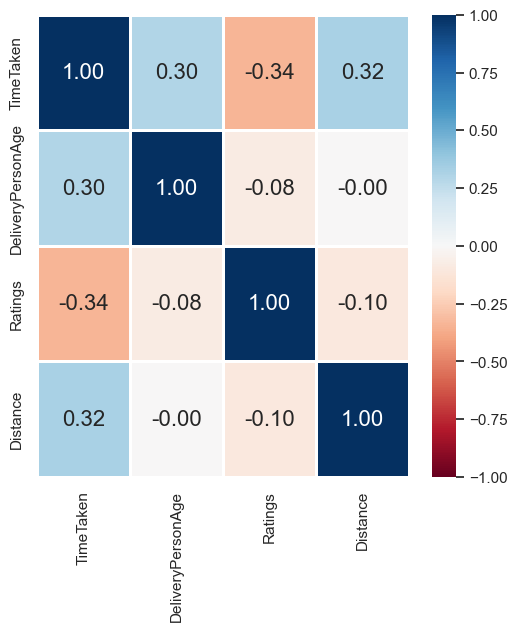

In [ ]:
df = data[["TimeTaken", "DeliveryPersonAge", "Ratings", "Distance"]]

f = plt.figure(figsize=(6, 6))
sb.heatmap(df.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 16}, cmap = "RdBu")

All three features have decent correlation and about the same degree of correlation, hence we will try to use both for linear regression.

### 1.1.2 Creating the model

In [ ]:
def univariateLinearRegression(Xvar = None, yvar = None, df = None):
    # Extract Response and Predictors
    y = pd.DataFrame(df[yvar])
    X = pd.DataFrame(df[Xvar])

    # Split the Dataset into random Train and Test (80:20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    linreg = LinearRegression()         # create the linear regression object
    linreg.fit(X_train, y_train)        # train the linear regression model

    # Print the coefficients of the Regression Line
    print('Intercept \t: b = ', linreg.intercept_)
    print('Coefficients \t: a = ', linreg.coef_)
    
    # Formula for the Regression line
    regline_x = X_train
    regline_y = linreg.intercept_ + linreg.coef_ * X_train
    
    # Predict Response corresponding to Predictors
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
    
    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    
    axes[0].scatter(X_train, y_train, color = "blue")
    axes[0].plot(regline_x, regline_y, 'r-', linewidth = 3)
    axes[0].set_title("Regression Line on Train Set")
    
    axes[1].scatter(X_test, y_test, color = "green")
    axes[1].scatter(X_test, y_test_pred, color = "red")
    axes[1].set_title("Model Prediction on Test Set")
    
    plt.show()
    compare = pd.DataFrame(np.array([[r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)], 
                                     [r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['Train Set','Test Set'])
    display(compare)
    
    results.append([r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)])
    Xvar = 'Age' if Xvar == "DeliveryPersonAge" else Xvar
    models.append(f'Uni LinReg {Xvar}')

Intercept 	: b =  [11.95632206]
Coefficients 	: a =  [[0.48615283]]


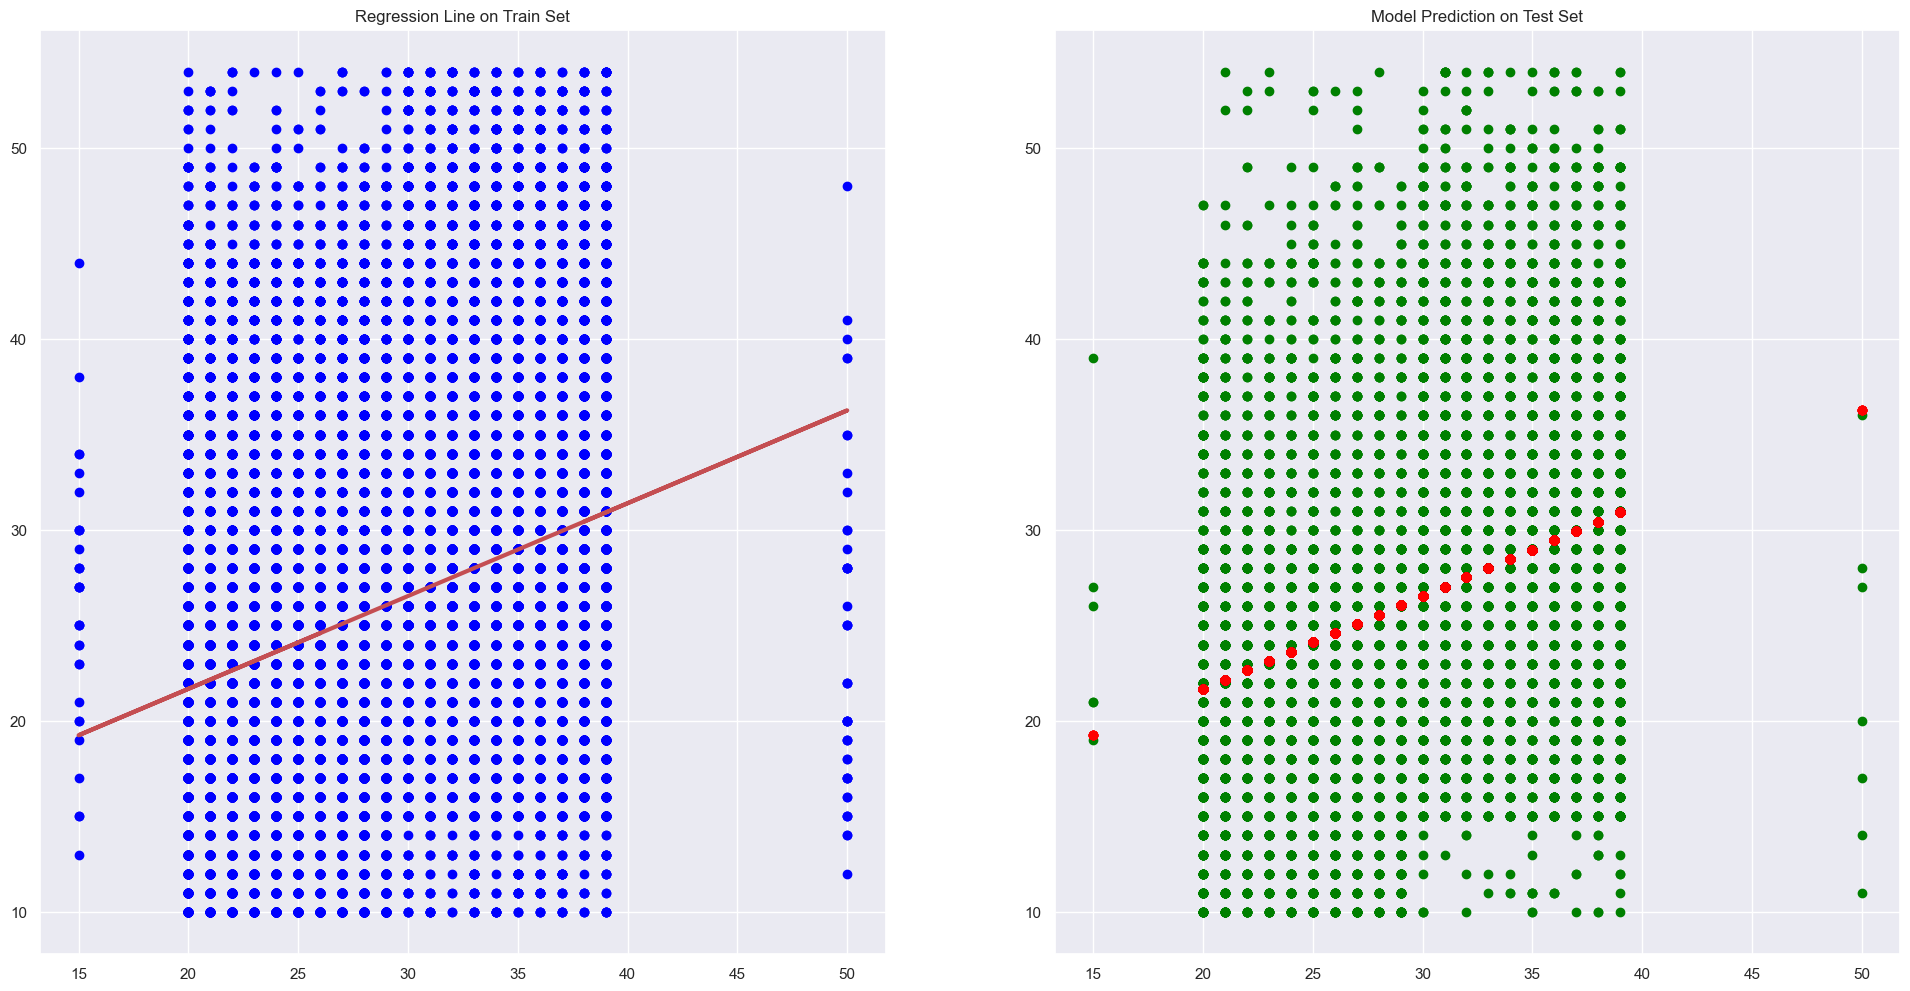

,R^2 Score,MSE
Train Set,0.091160,79.855369
Test Set,0.082976,80.162816


In [ ]:
univariateLinearRegression(Xvar = "DeliveryPersonAge", yvar = "TimeTaken", df = data)

Intercept 	: b =  [70.66478282]
Coefficients 	: a =  [[-9.57180853]]


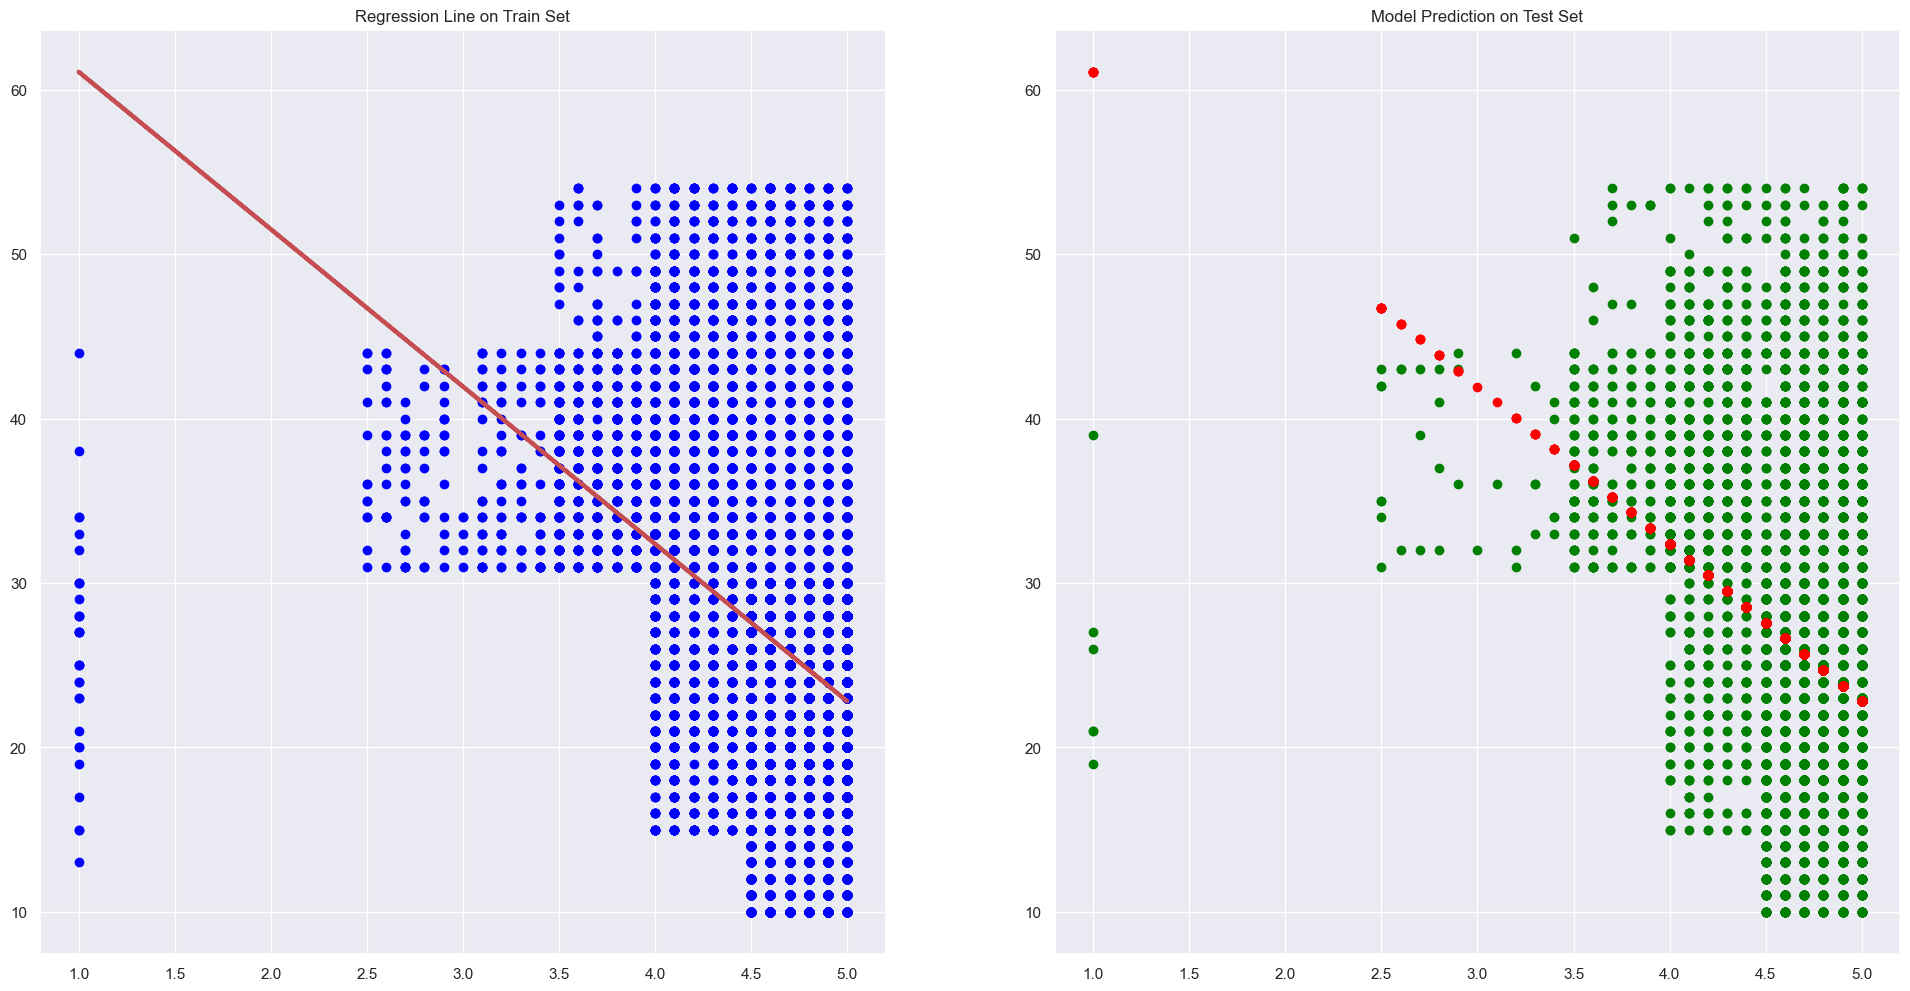

,R^2 Score,MSE
Train Set,0.116175,77.657425
Test Set,0.116581,77.225152


In [ ]:
univariateLinearRegression(Xvar = "Ratings", yvar = "TimeTaken", df = data)

Intercept 	: b =  [20.98569815]
Coefficients 	: a =  [[0.54821794]]


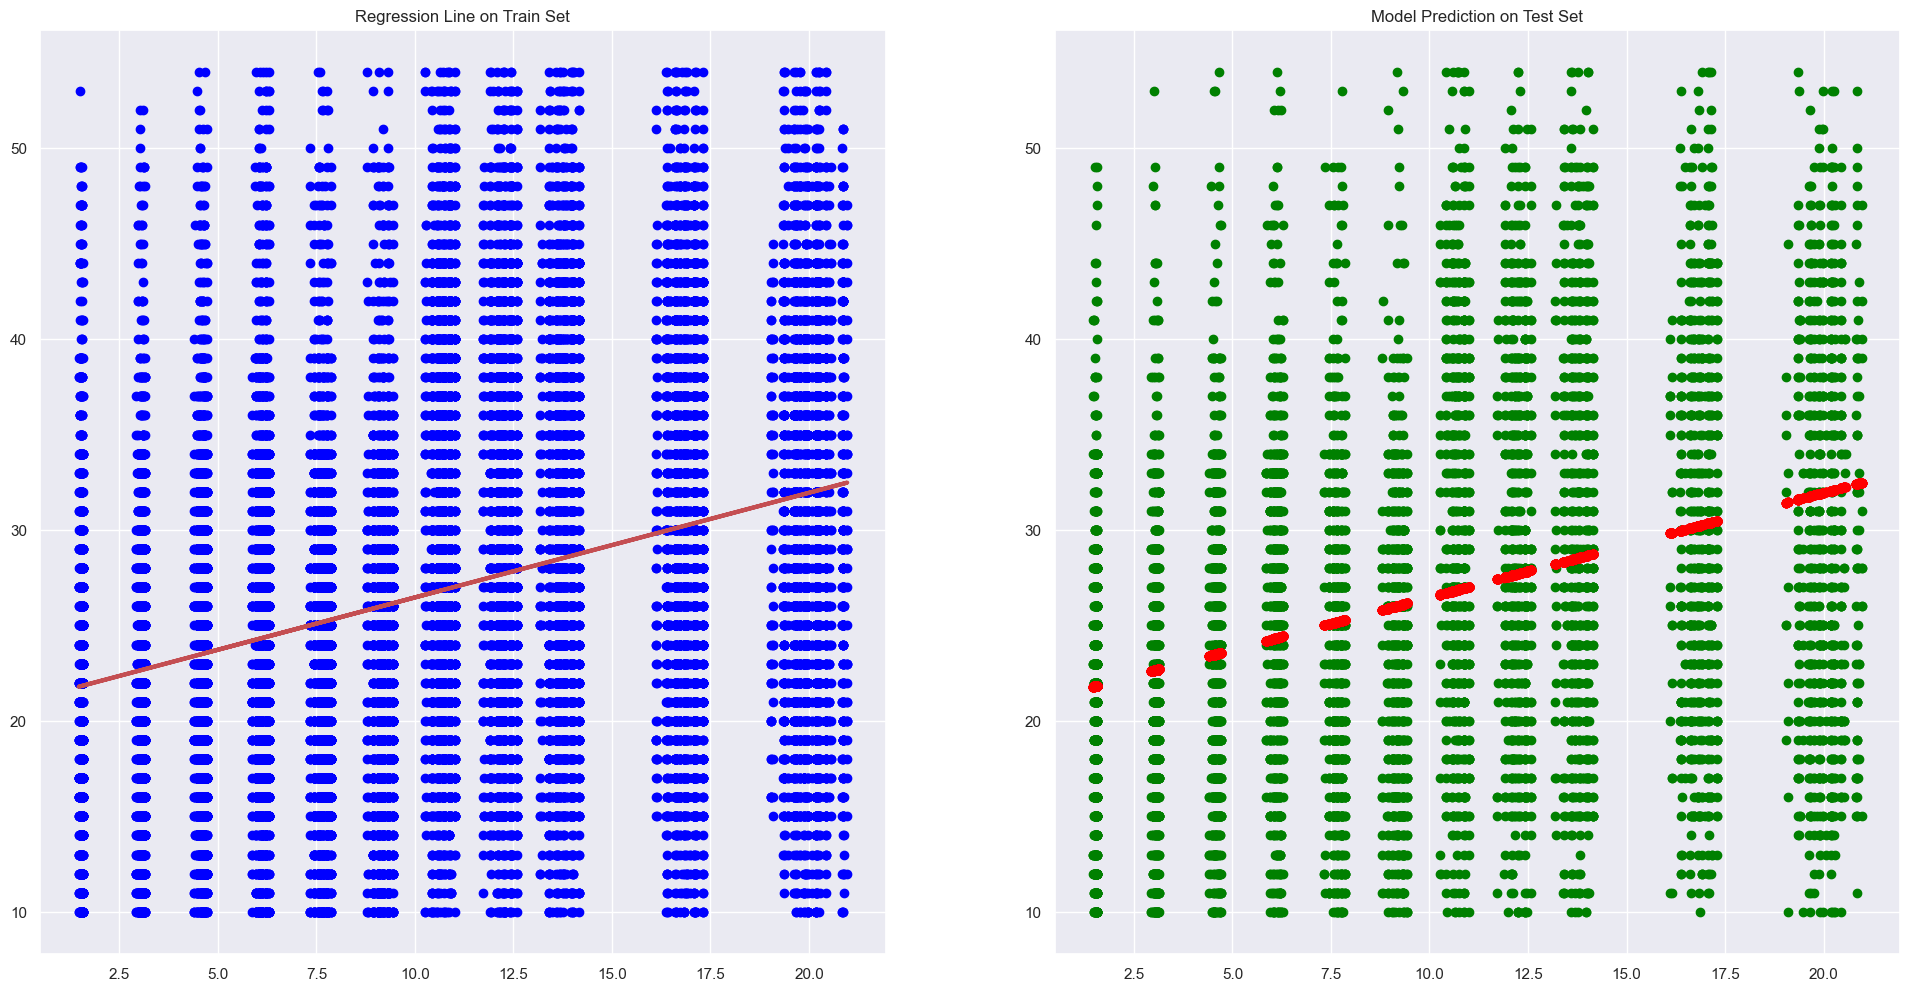

,R^2 Score,MSE
Train Set,0.107293,78.437862
Test Set,0.086230,79.878353


In [ ]:
univariateLinearRegression(Xvar = "Distance", yvar = "TimeTaken", df = data)

## 1.2 Multivariate Linear Regression

Using only 1 variable to predict yields bad results, hence we will try multivariate regresison to improve the results. We will use all three `DeliveryPersonAge`,`Ratings`, and `Distance` to predict `TimeTaken`.

In [ ]:
# Extract Response and Predictors
y = pd.DataFrame(data['TimeTaken'])
X = pd.DataFrame(data[["DeliveryPersonAge", "Ratings", "Distance"]])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

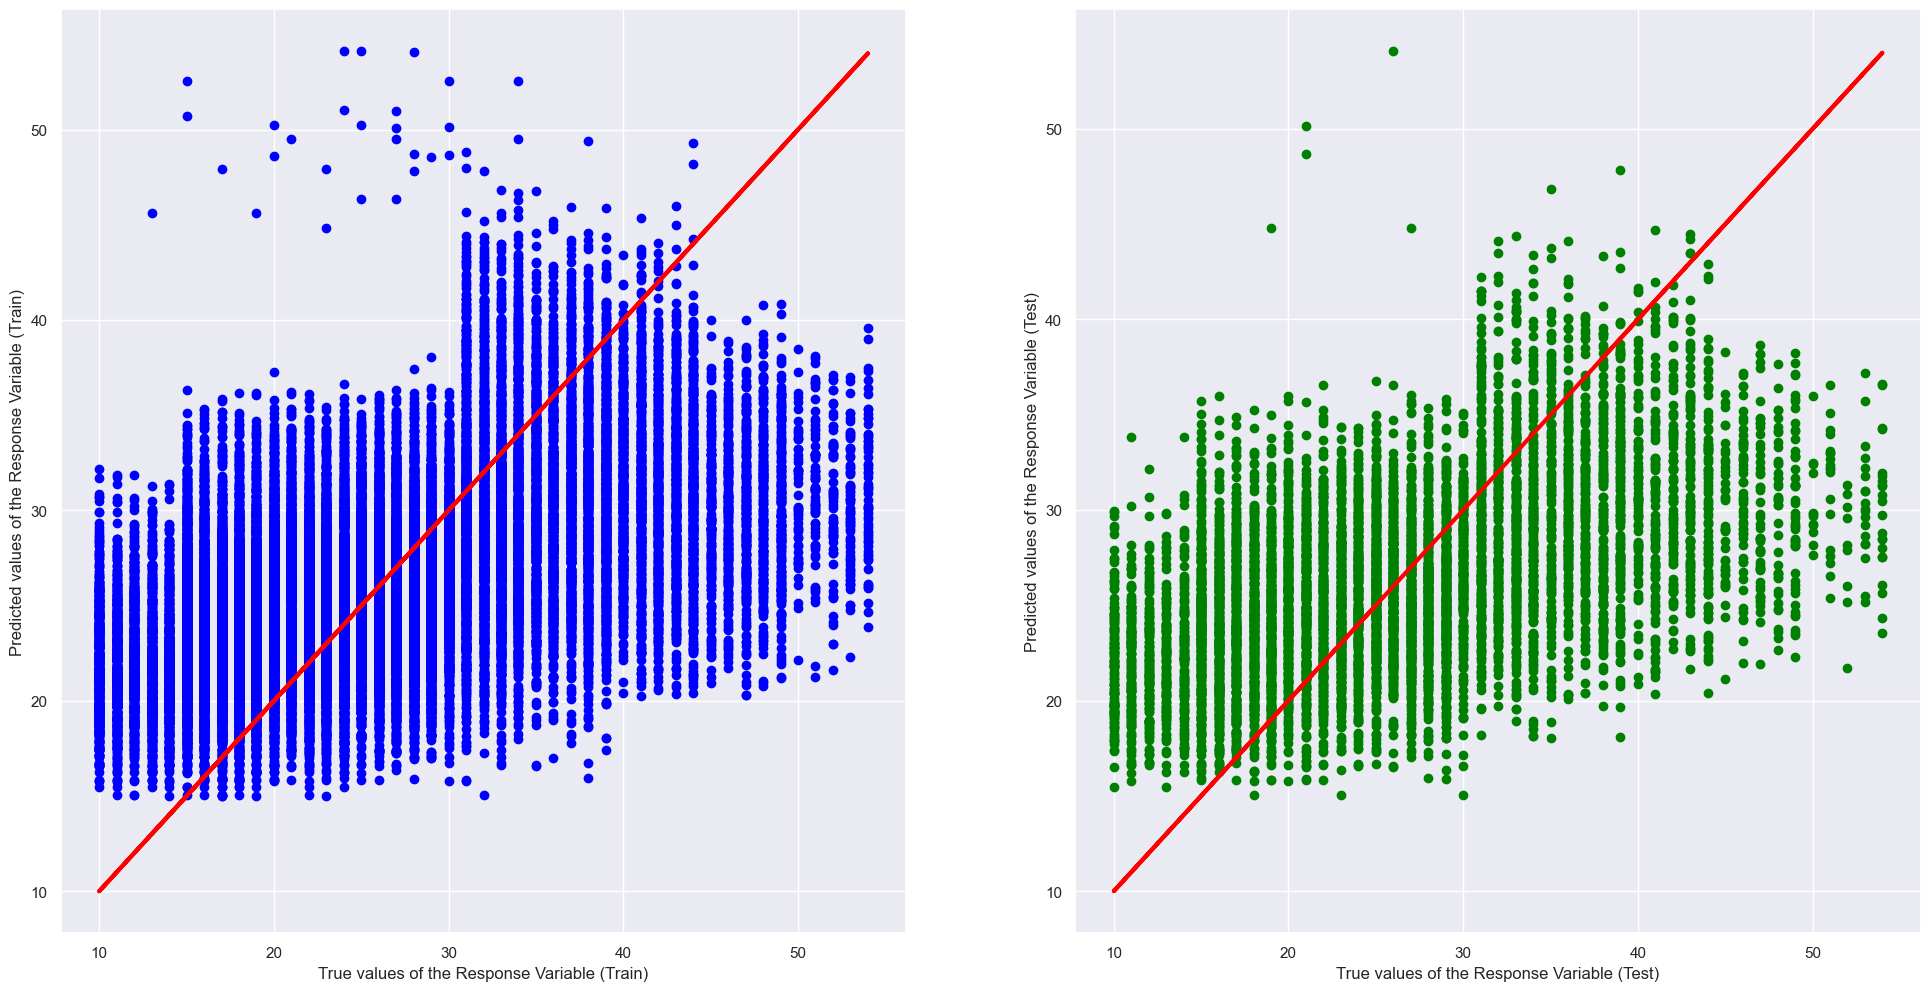

In [ ]:
# Predict on train and test sets
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'red', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'red', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [ ]:
compare = pd.DataFrame(np.array([[r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)], 
                                     [r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['Train Set','Test Set'])
display(compare)

results.append([r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)])
models.append(f'Multi LinReg')

,R^2 Score,MSE
Train Set,0.278113,63.428674
Test Set,0.262070,64.507023


We can see that distance has provided us a boost as our MSE has decreased and R^2 has increased. Moving forward, we will be using `Distance` in this notebook for our other models.

# 2. Using both Categorical & Numerical Data

In [ ]:
categoricalData = ['WeatherConditions', 'RoadTrafficDensity', 'VechicleCondition','TypeOfOrder','TypeOfVehicle',
                   'MultipleDeliveries','Festival','City']
row = []
for x in categoricalData:
    row.append([data[x].nunique(), data[x].unique()])
    
compare = pd.DataFrame(row, columns = ['Number', 'Categories'], 
                      index = categoricalData)

pd.set_option('max_colwidth', 100)
display(compare)

,Number,Categories
WeatherConditions,6,"[Sunny, Stormy, Sandstorms, Cloudy, Fog, Windy, nan]"
RoadTrafficDensity,4,"[High, Jam, Low, Medium]"
VechicleCondition,4,"[2, 0, 1, 3]"
TypeOfOrder,4,"[Snack, Drinks, Buffet, Meal]"
TypeOfVehicle,4,"[Motorcycle, Scooter, Electric_scooter, Bicycle]"
MultipleDeliveries,4,"[0, 1, 3, 2]"
Festival,2,"[No, Yes, nan]"
City,3,"[Urban, Metropolitian, Semi-Urban]"


## 2.1 General Feature Selection & Data Preparation

### 2.1.1 See distribution of each categorical feature

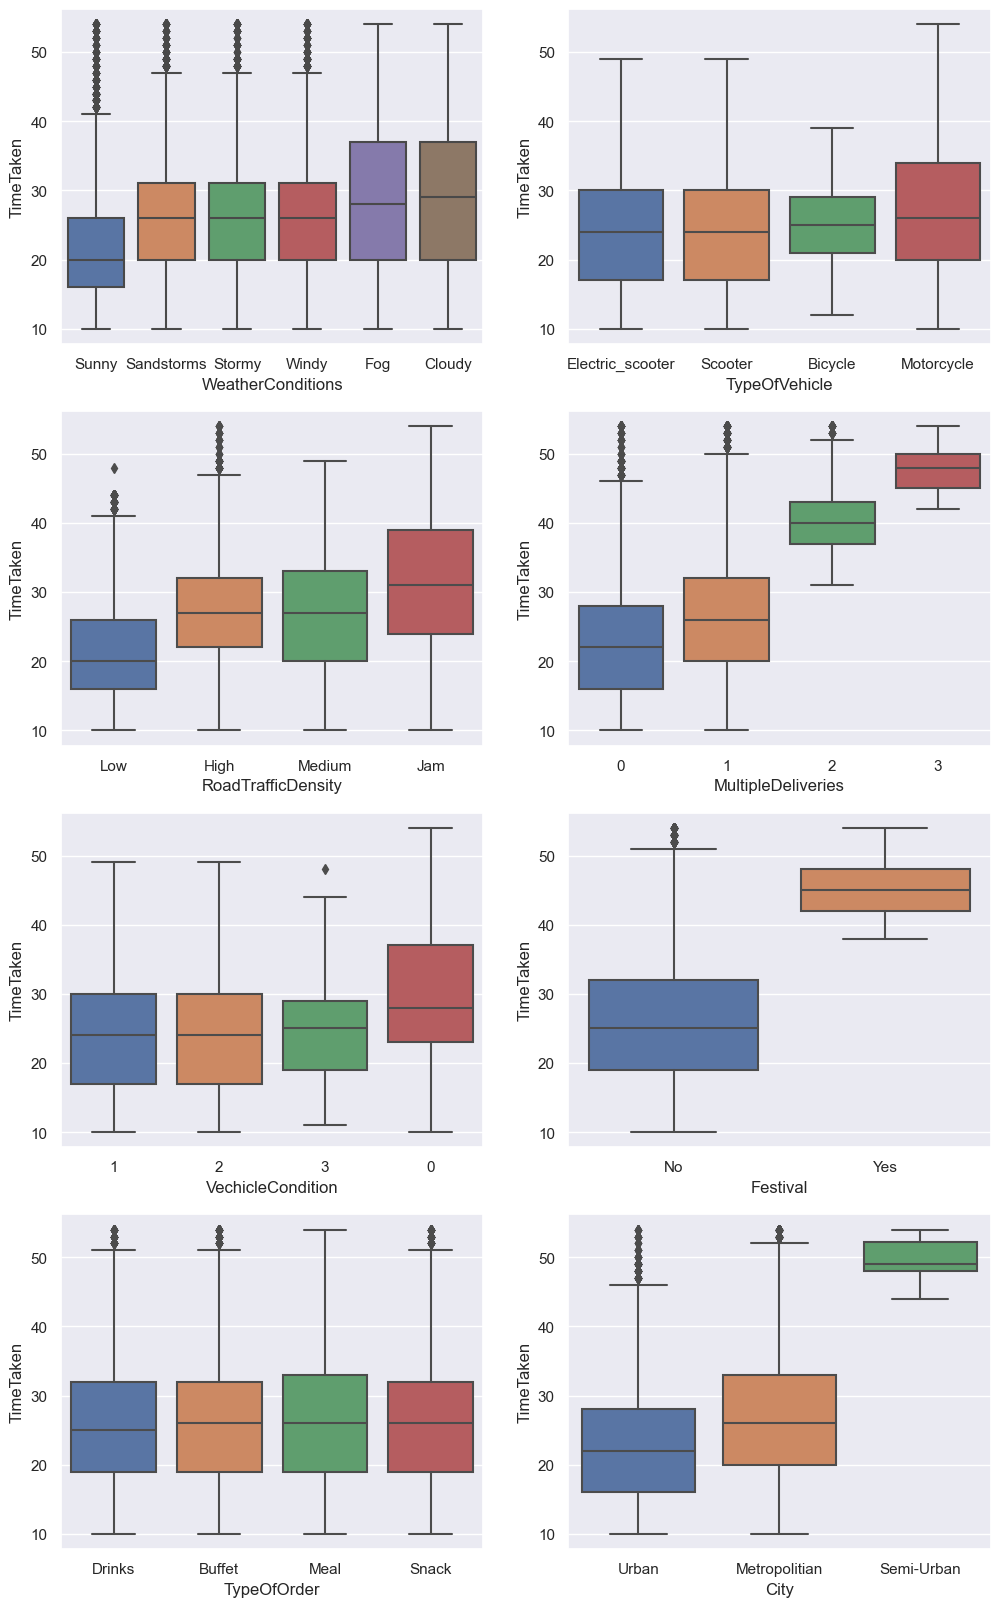

In [ ]:
categoricalData = ['WeatherConditions', 'RoadTrafficDensity', 'VechicleCondition','TypeOfOrder']

f, axes = plt.subplots(4, 2, figsize=(12,20))
for i,x in enumerate(categoricalData):
    order = data.groupby(by=[x])["TimeTaken"].median().sort_values().index
    sb.boxplot(data=data, x=x, y='TimeTaken', ax = axes[i,0], order=order)
    
categoricalData = ['TypeOfVehicle','MultipleDeliveries','Festival','City']

for i,x in enumerate(categoricalData):
    order = data.groupby(by=[x])["TimeTaken"].median().sort_values().index
    sb.boxplot(data=data, x=x, y='TimeTaken', ax = axes[i,1], order=order)
plt.show()

### 2.1.2 ANOVA Test to quantify and verify observations from the distributions

In [ ]:
categoricalData = ['WeatherConditions', 'RoadTrafficDensity', 'VechicleCondition','TypeOfOrder','TypeOfVehicle',
                   'MultipleDeliveries','City','Festival']

row = []
for x in categoricalData:
    CategoryGroupLists=data.groupby(x)['TimeTaken'].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)
    row.append([AnovaResults[0], AnovaResults[1]])
    
compare = pd.DataFrame(row, columns = ['F-Value', 'P-Value'], 
                      index = categoricalData)

pd.set_option('max_colwidth', 100)
display(compare)

,F-Value,P-Value
WeatherConditions,594.653620,0.000000e+00
RoadTrafficDensity,3264.776322,0.000000e+00
VechicleCondition,1272.417725,0.000000e+00
TypeOfOrder,1.031479,3.773037e-01
TypeOfVehicle,412.443909,3.121529e-264
MultipleDeliveries,3279.864846,0.000000e+00
City,1283.722912,0.000000e+00
Festival,3997.863317,0.000000e+00


### 2.1.3. Encode using One Hot Encoding

In [ ]:
ohe = OneHotEncoder()

dataOH = data[['RoadTrafficDensity','MultipleDeliveries','Festival', 'City', 'VechicleCondition', 
               'TypeOfVehicle', 'WeatherConditions']]
ohe.fit(dataOH)
dataOH = pd.DataFrame(ohe.transform(dataOH).toarray(), 
                                  columns=ohe.get_feature_names_out(dataOH.columns))

dataOH = pd.concat([data[['TimeTaken', 'DeliveryPersonAge', 'Ratings', 'Distance']].reset_index(drop=True),
                    dataOH.reset_index(drop=True)], axis = 1)

dataOH.head()

,TimeTaken,DeliveryPersonAge,Ratings,Distance,RoadTrafficDensity_High,RoadTrafficDensity_Jam,RoadTrafficDensity_Low,RoadTrafficDensity_Medium,MultipleDeliveries_0,MultipleDeliveries_1,...,TypeOfVehicle_Electric_scooter,TypeOfVehicle_Motorcycle,TypeOfVehicle_Scooter,WeatherConditions_Cloudy,WeatherConditions_Fog,WeatherConditions_Sandstorms,WeatherConditions_Stormy,WeatherConditions_Sunny,WeatherConditions_Windy,WeatherConditions_nan
0,24,37,4.9,3.025149,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,33,34,4.5,20.183530,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,26,23,4.4,1.552758,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,21,38,4.7,7.790401,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,30,32,4.6,6.210138,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.1.4. Splitting the Data

In [ ]:
x = dataOH.drop(['TimeTaken'], axis = 1)
y = dataOH['TimeTaken']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)

## 2.2 Decision Tree & Random Forest

### 2.2.1 Feature selection using random forest

In [ ]:
RF = RandomForestRegressor( criterion = 'squared_error', random_state = 42)
RF.fit(x_train, y_train)

importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(RF.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
Ratings,0.221
Distance,0.174
RoadTrafficDensity_Low,0.128
DeliveryPersonAge,0.118
VechicleCondition_0,0.087
WeatherConditions_Sunny,0.082
WeatherConditions_Fog,0.051
WeatherConditions_Cloudy,0.048
RoadTrafficDensity_Medium,0.021


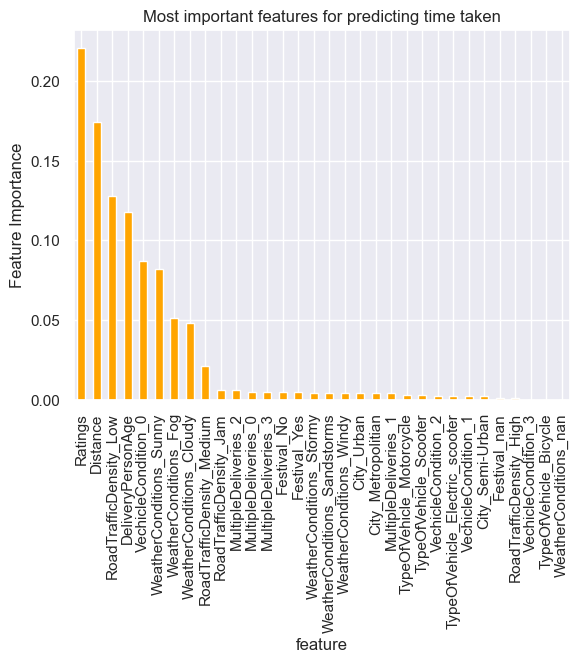

In [ ]:
importances.plot(kind='bar', color = "orange", title = "Most important features for predicting time taken", legend = None)
plt.ylabel('Feature Importance')
plt.show()

We will only be using only the top 10 features, drop the rest.

In [ ]:
newfeats_x_train = x_train[['Distance', 'Ratings','DeliveryPersonAge', 'RoadTrafficDensity_Low', 'VechicleCondition_0', 
                      'WeatherConditions_Sunny','RoadTrafficDensity_Jam', 'MultipleDeliveries_2', 
                      'WeatherConditions_Cloudy']]
newfeats_x_test = x_test[['Distance', 'Ratings','DeliveryPersonAge', 'RoadTrafficDensity_Low', 'VechicleCondition_0', 
                         'WeatherConditions_Sunny','RoadTrafficDensity_Jam', 'MultipleDeliveries_2', 
                         'WeatherConditions_Cloudy']]

### 2.2.2. Modelling the decision tree

,R^2 Score,MSE
Decision Tree,0.434871,49.40141


Tree Depth 3
Terminal Nodes 8


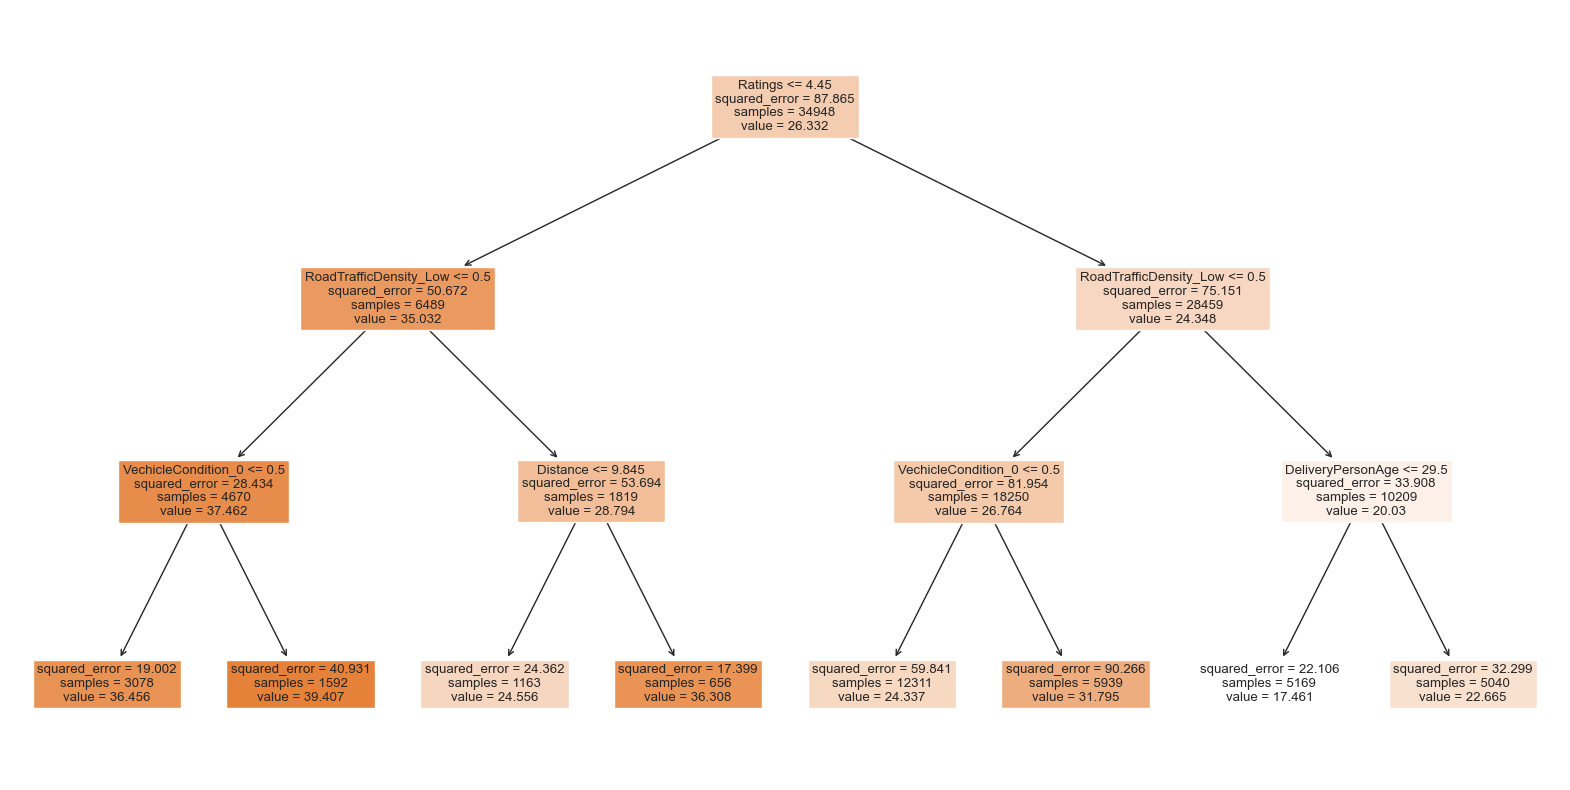

In [ ]:
dtree = DecisionTreeRegressor(random_state = 42, max_depth = 3)
dtree.fit(newfeats_x_train,y_train)

dtree_pred = dtree.predict(newfeats_x_test)
r2 = r2_score(y_test, dtree_pred)
mse = mean_squared_error(y_test, dtree_pred)

compare = pd.DataFrame(np.array([[r2, mse]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['Decision Tree'])
display(compare)

print("Tree Depth",dtree.get_depth())
print("Terminal Nodes", dtree.get_n_leaves())

_, ax = plt.subplots(figsize=(20,10)) # Resize figure
plot_tree(dtree, filled=True, ax=ax, feature_names=newfeats_x_train.columns.tolist())
plt.show()

results.append([r2, mse])
models.append('Decision Tree')

### 2.2.3. Modelling the Random Forest

#### 2.2.3.1. Normal random forest

In [ ]:
rforest = RandomForestRegressor( criterion = 'squared_error', random_state = 42, n_estimators = 100)
rforest.fit(newfeats_x_train, y_train)

rforest_pred = rforest.predict(newfeats_x_test)
r2 = r2_score(y_test, rforest_pred)
mse = mean_squared_error(y_test, rforest_pred)

compare = pd.DataFrame(np.array([[r2, mse]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['Random Forest'])
display(compare)

results.append([r2, mse])
models.append('Random Forest')

,R^2 Score,MSE
Random Forest,0.708304,25.498985


#### 2.2.3.2 Random forest with Grid Search Cross Validation

In [ ]:
param_grid = {
    'max_depth': [2,4,6,8,10,12],
    'max_features': ['sqrt', 'log2', None],
}

rf_grid_search = GridSearchCV(rforest, param_grid=param_grid,
                              cv = 3, scoring = 'neg_mean_squared_error',
                              return_train_score = True )

rf_grid_search.fit(newfeats_x_train, y_train)
rf_grid_search.best_params_

rforest_grid_search_pred = rf_grid_search.predict(newfeats_x_test)
r2 = r2_score(y_test, rforest_grid_search_pred)
mse = mean_squared_error(y_test, rforest_grid_search_pred)

compare = pd.DataFrame(np.array([[r2, mse]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['Random Forest with CV'])
display(compare)

results.append([r2, mse])
models.append('Random Forest CV')

,R^2 Score,MSE
Random Forest with CV,0.752352,21.648436


## 2.3 Lasso Regression

### 2.3.1 Feature Selection

In [ ]:
lassocv = LassoCV(cv = 10)

lassocv.fit(x_train, y_train)
alpha = lassocv.alpha_
print("Best alpha :", alpha)

Best alpha : 0.01719624769045847


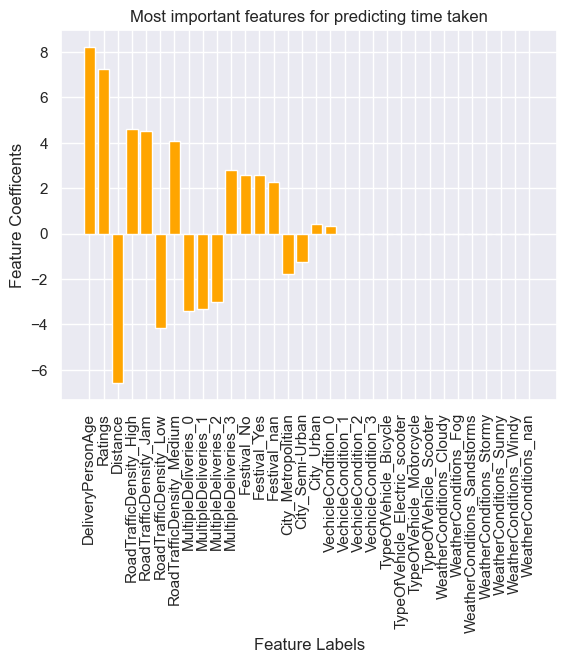

In [ ]:
lasso_selector = SelectFromModel(Lasso(alpha = alpha, random_state = 42))
lasso_selector.fit(x_train, y_train)

coefs = lassocv.coef_
plt.bar(x_train.columns, sorted(coefs, key = lambda x: abs(x), reverse = True), color = 'orange')
plt.xticks(rotation = 'vertical')
plt.xlabel('Feature Labels')
plt.ylabel('Feature Coefficents')
plt.title('Most important features for predicting time taken')
plt.show()

We will use all 17 non-zero features.

In [ ]:
newfeats_x_train = x_train[['Distance', 'DeliveryPersonAge', 'Ratings', 'RoadTrafficDensity_High', 'RoadTrafficDensity_Jam',
                            'RoadTrafficDensity_Low', 'RoadTrafficDensity_Medium', 'MultipleDeliveries_0',
                            'MultipleDeliveries_1', 'MultipleDeliveries_2', 'MultipleDeliveries_3',
                            'Festival_No', 'Festival_Yes', 'City_Metropolitian', 'City_Semi-Urban', 'City_Urban',
                            'VechicleCondition_0']]
newfeats_x_test = x_test[['Distance', 'DeliveryPersonAge', 'Ratings', 'RoadTrafficDensity_High', 'RoadTrafficDensity_Jam',
                            'RoadTrafficDensity_Low', 'RoadTrafficDensity_Medium', 'MultipleDeliveries_0',
                            'MultipleDeliveries_1', 'MultipleDeliveries_2', 'MultipleDeliveries_3',
                            'Festival_No', 'Festival_Yes', 'City_Metropolitian', 'City_Semi-Urban', 'City_Urban',
                            'VechicleCondition_0']]

### 2.3.2 Modelling the lasso regression

,R^2 Score,MSE
Lasso Regression,0.556791,38.74366


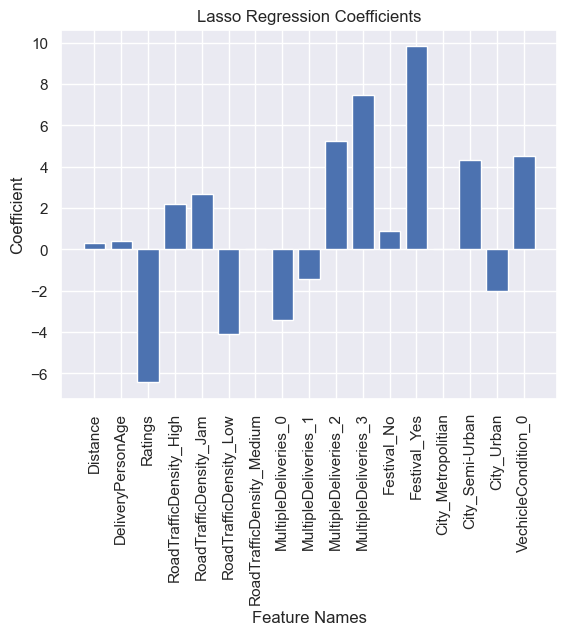

In [ ]:
lasso_reg = Lasso(alpha = alpha, random_state = 42)
lasso_reg.fit(newfeats_x_train, y_train)

lasso_reg_pred = lasso_reg.predict(newfeats_x_test)
r2 = r2_score(y_test, lasso_reg_pred)
mse = mean_squared_error(y_test, lasso_reg_pred)

compare = pd.DataFrame(np.array([[r2, mse]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['Lasso Regression'])
display(compare)

plt.figure()
plt.bar(lasso_reg.feature_names_in_, lasso_reg.coef_)
plt.xlabel('Feature Names')
plt.xticks(rotation=90)
plt.ylabel('Coefficient')
plt.title('Lasso Regression Coefficients')
plt.show()

results.append([r2, mse])
models.append('Lasso Regression')

## 2.4 XGBoost

### 2.4.1 Normal XGBoost

XGBoost without feature selection, uses all features except TypeOfOrder. Then we will use XGBCrossValidation to imporve it further.

In [ ]:
xgb_reg = XGBRegressor(n_estimators=25,learning_rate=0.1,alpha=0.1,seed=42).fit(x_train, y_train)
xgb_reg_pred = xgb_reg.predict(x_test)

r2 = r2_score(y_test, xgb_reg_pred)
mse = mean_squared_error(y_test, xgb_reg_pred)

compare = pd.DataFrame(np.array([[r2, mse]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['Normal XGBoost'])
display(compare)

results.append([r2, mse])
models.append('XGBoost')

,R^2 Score,MSE
Normal XGBoost,0.762962,20.721002


### 2.4.2 Cross Validation XGBoost

In [ ]:
class SaveBestModel(xgb.callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters
    
    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model
    
cvboosters = []

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 150, 'alpha': 10}

data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=150, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42,
                    callbacks=[SaveBestModel(cvboosters), ])

display(xgb_cv)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,25.039854,0.013410,25.039720,0.133293
1,22.780300,0.023139,22.784067,0.145627
2,20.750912,0.051550,20.749018,0.171320
3,18.929342,0.056926,18.928214,0.157058
4,17.308647,0.072717,17.305797,0.169277
...,...,...,...,...
145,2.920277,0.096844,4.247023,0.062381
146,2.913103,0.090186,4.245748,0.061728
147,2.900926,0.087906,4.243912,0.060424
148,2.894220,0.088912,4.242872,0.060292


In [ ]:
dtest = xgb.DMatrix(data=x_test)
xgb_cv_pred = cvboosters[0].predict(dtest)

r2 = r2_score(y_test, xgb_cv_pred)
mse = mean_squared_error(y_test, xgb_cv_pred)

compare = pd.DataFrame(np.array([[r2, mse]]), 
                      columns=['R^2 Score', 'MSE'], 
                      index =['CV XGBoost'])
display(compare)

results.append([r2, mse])
models.append('XGBoost CV')

,R^2 Score,MSE
CV XGBoost,0.796479,17.791027


# 3. Results

In [ ]:
compare = pd.DataFrame(results, 
                      columns=['R^2 Score', 'MSE'], 
                      index = models)
display(compare)

,R^2 Score,MSE
Uni LinReg Age,0.082976,80.162816
Uni LinReg Ratings,0.116581,77.225152
Uni LinReg Distance,0.086230,79.878353
Multi LinReg,0.262070,64.507023
Decision Tree,0.434871,49.401410
Random Forest,0.708304,25.498985
Random Forest CV,0.752352,21.648436
Lasso Regression,0.556791,38.743660
XGBoost,0.762962,20.721002
XGBoost CV,0.796479,17.791027


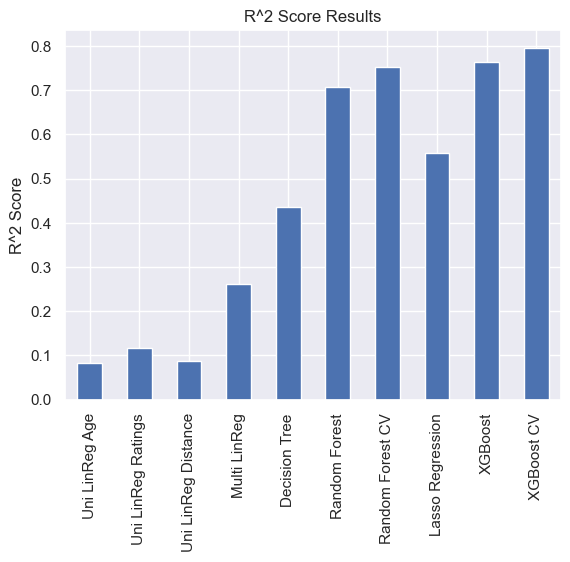

In [ ]:
r2compare = compare['R^2 Score']

r2compare.plot(kind='bar', title = "R^2 Score Results", legend = None)

plt.ylabel('R^2 Score')
plt.show()

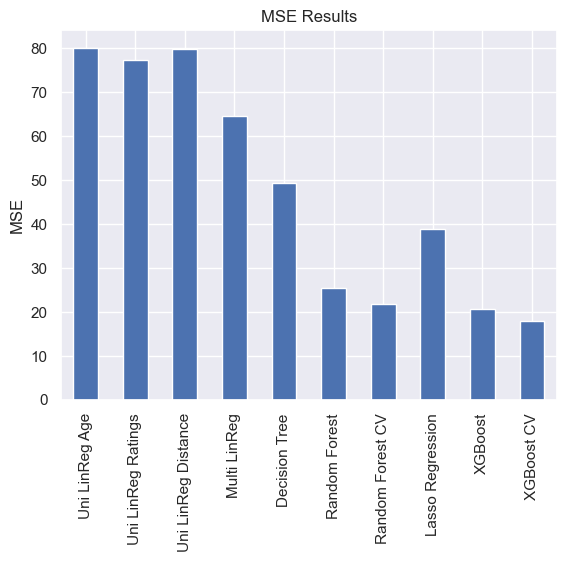

In [ ]:
msecompare = compare['MSE']

msecompare.plot(kind='bar', title = "MSE Results", legend = None)

plt.ylabel('MSE')
plt.show()

# 4. Compare with Previous Model

We will compare the models with `Distance` feature vs models without `Distance` feature.

In [ ]:
prevData = pd.read_csv('prev_model_results.csv', index_col=0).drop(['Uni LinReg Age', 'Uni LinReg Ratings'], axis=0)
curData = compare.drop(['Uni LinReg Age', 'Uni LinReg Ratings', 'Uni LinReg Distance'], axis=0)

r2compare = prevData.drop('MSE', axis=1).rename(columns={'R^2 Score': 'Old R^2 Score'})
insert = curData['R^2 Score']
r2compare['New R^2 Score'] = insert

display(r2compare)

,Old R^2 Score,New R^2 Score
Multi LinReg,0.187739,0.262070
Decision Tree,0.427998,0.434871
Random Forest,0.626945,0.708304
Random Forest CV,0.657132,0.752352
Lasso Regression,0.531724,0.556791
XGBoost,0.661872,0.762962
XGBoost CV,0.705442,0.796479


In [ ]:
msecompare = prevData.drop('R^2 Score', axis=1).rename(columns={'MSE': 'Old MSE'})
insert = curData['MSE']
msecompare['New MSE'] = insert

display(msecompare)

,Old MSE,New MSE
Multi LinReg,71.004839,64.507023
Decision Tree,50.002259,49.401410
Random Forest,32.611058,25.498985
Random Forest CV,29.972224,21.648436
Lasso Regression,40.934936,38.743660
XGBoost,29.557848,20.721002
XGBoost CV,25.749111,17.791027


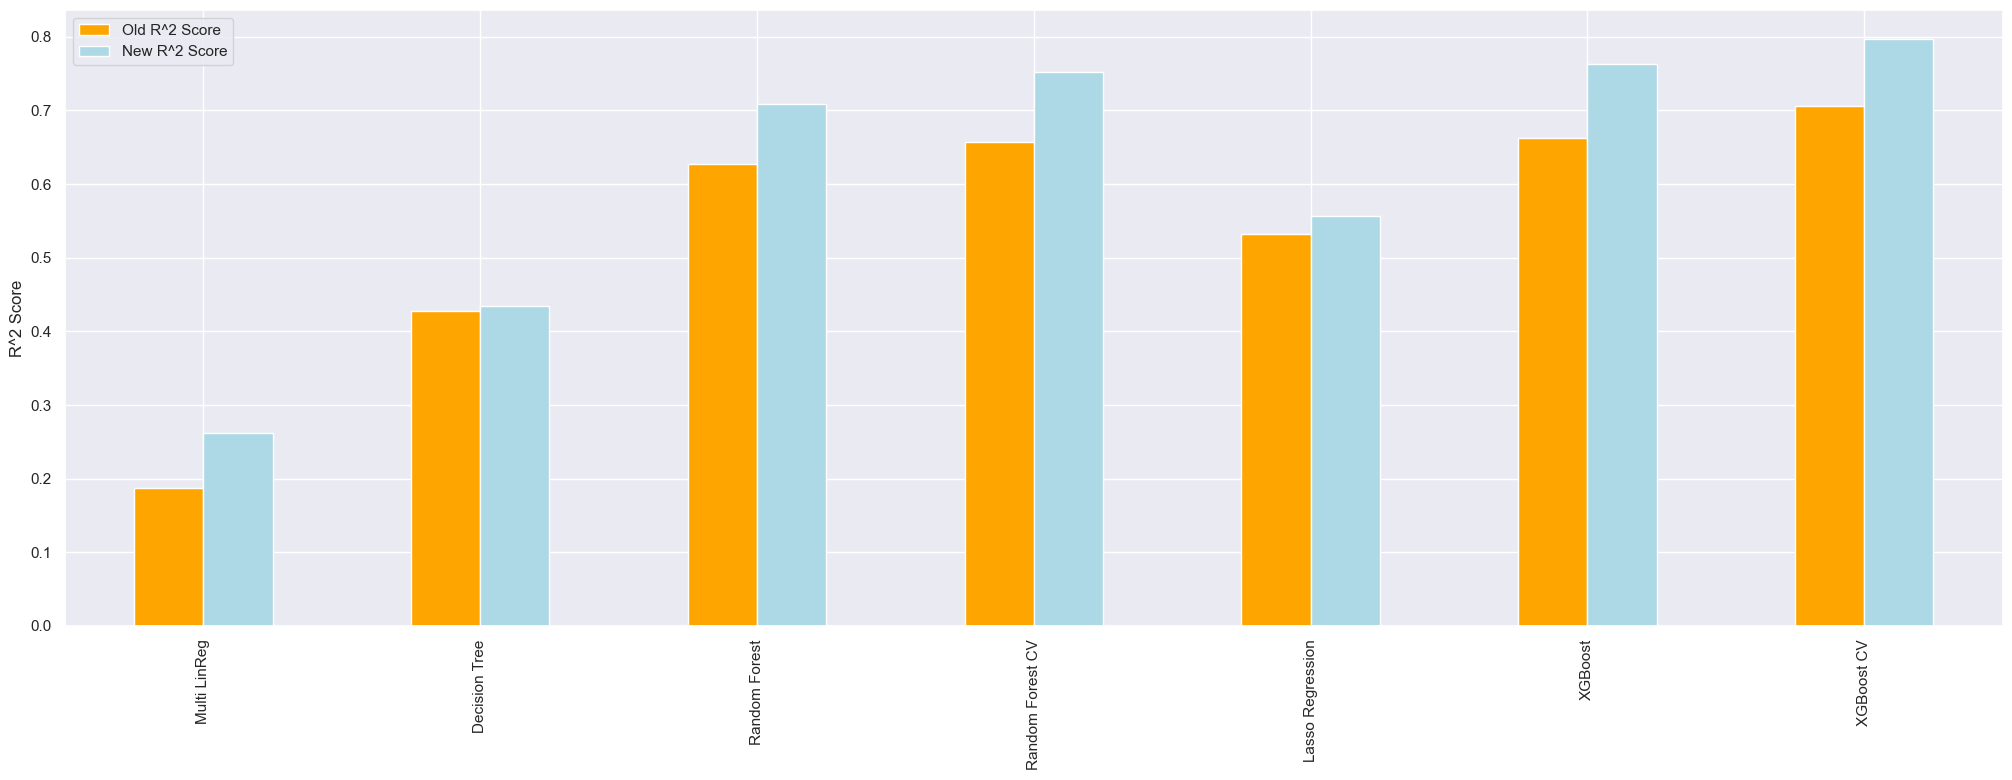

In [ ]:
r2compare.plot(kind='bar', color = ('lightblue', 'orange'), figsize = (25,8))
plt.ylabel("R^2 Score")
plt.show()

In [ ]:
msecompare.plot(kind='bar', color = ('orange','lightblue'), figsize = (25,8))
plt.ylabel("R^2 Score")
plt.show()